# Boundary Layer Cross-sections

This notebook plots the temperature conditions of the boundary layer, as a function of the x-coordinate and the distance from the ice shelf, for each model at the end of the Ocean0, Ocean1 and Ocean2 runs.

still WIP. adding more details

**Issues**: 
- How far in the x-direction should we focus on?

In [2]:
#Load required packages
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import cftime
import cmocean as cm

from netCDF4 import Dataset
import os.path
import matplotlib.colors as colors

Models: 
```
COCO   MITgcm-BAS          MITgcm-JPL  MOM6_SIGMA_ZSTAR  NEMO-CNRS      POP2x
FVCOM  MITgcm_BAS_Coupled  MOM6        MPAS-Ocean        NEMO-UKESM1is  ROMS-UTAS
```

In [3]:
## folder where the isomip-plus github repo is located
baserepo = '../../'
## folder where you downloaded the zipped Google Drive data
basedrive = '../../../raw_data/ISOMIP+Data/'

# load the data from the text files, which point to the right location of the file in the drive structure
Ocean0_COM = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean0-COM.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean1_COM = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean1-COM.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean2_COM = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean2-COM.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean0_TYP = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean0-TYP.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean1_TYP = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean1-TYP.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean2_TYP = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean2-TYP.txt', dtype = 'str', delimiter = ',',usecols = 0)


# Ocean0 Vertical transect of temperature - modifying plotting choices for guidelines


no time dimension in  COCO  ice draft
CHECK is this the correct transect location?
removing time dimension from FVCOM ice draft
CHECK is this the correct transect location?
no time dimension in  MITgcm BAS  ice draft
CHECK is this the correct transect location?
no time dimension in  MITgcm BAS CoupledV3  ice draft
CHECK is this the correct transect location?
no time dimension in  MITgcm JPL  ice draft
CHECK is this the correct transect location?
no time dimension in  MOM6 SIGMA ZSTAR  ice draft
CHECK is this the correct transect location?
no time dimension in  MOM6  ice draft
CHECK is this the correct transect location?
no time dimension in  MPAS-Ocean  ice draft
CHECK is this the correct transect location?
no time dimension in  NEMO-CNRS  ice draft
CHECK is this the correct transect location?
This model  NEMO-CNRS/Ocean0-2 COM/Ocean0_COM_NEMO-CNRS.nc  has an inverted iceDraft - flipping to match others
no time dimension in  NEMO-UKESM1is  ice draft
CHECK is this the correct transect l

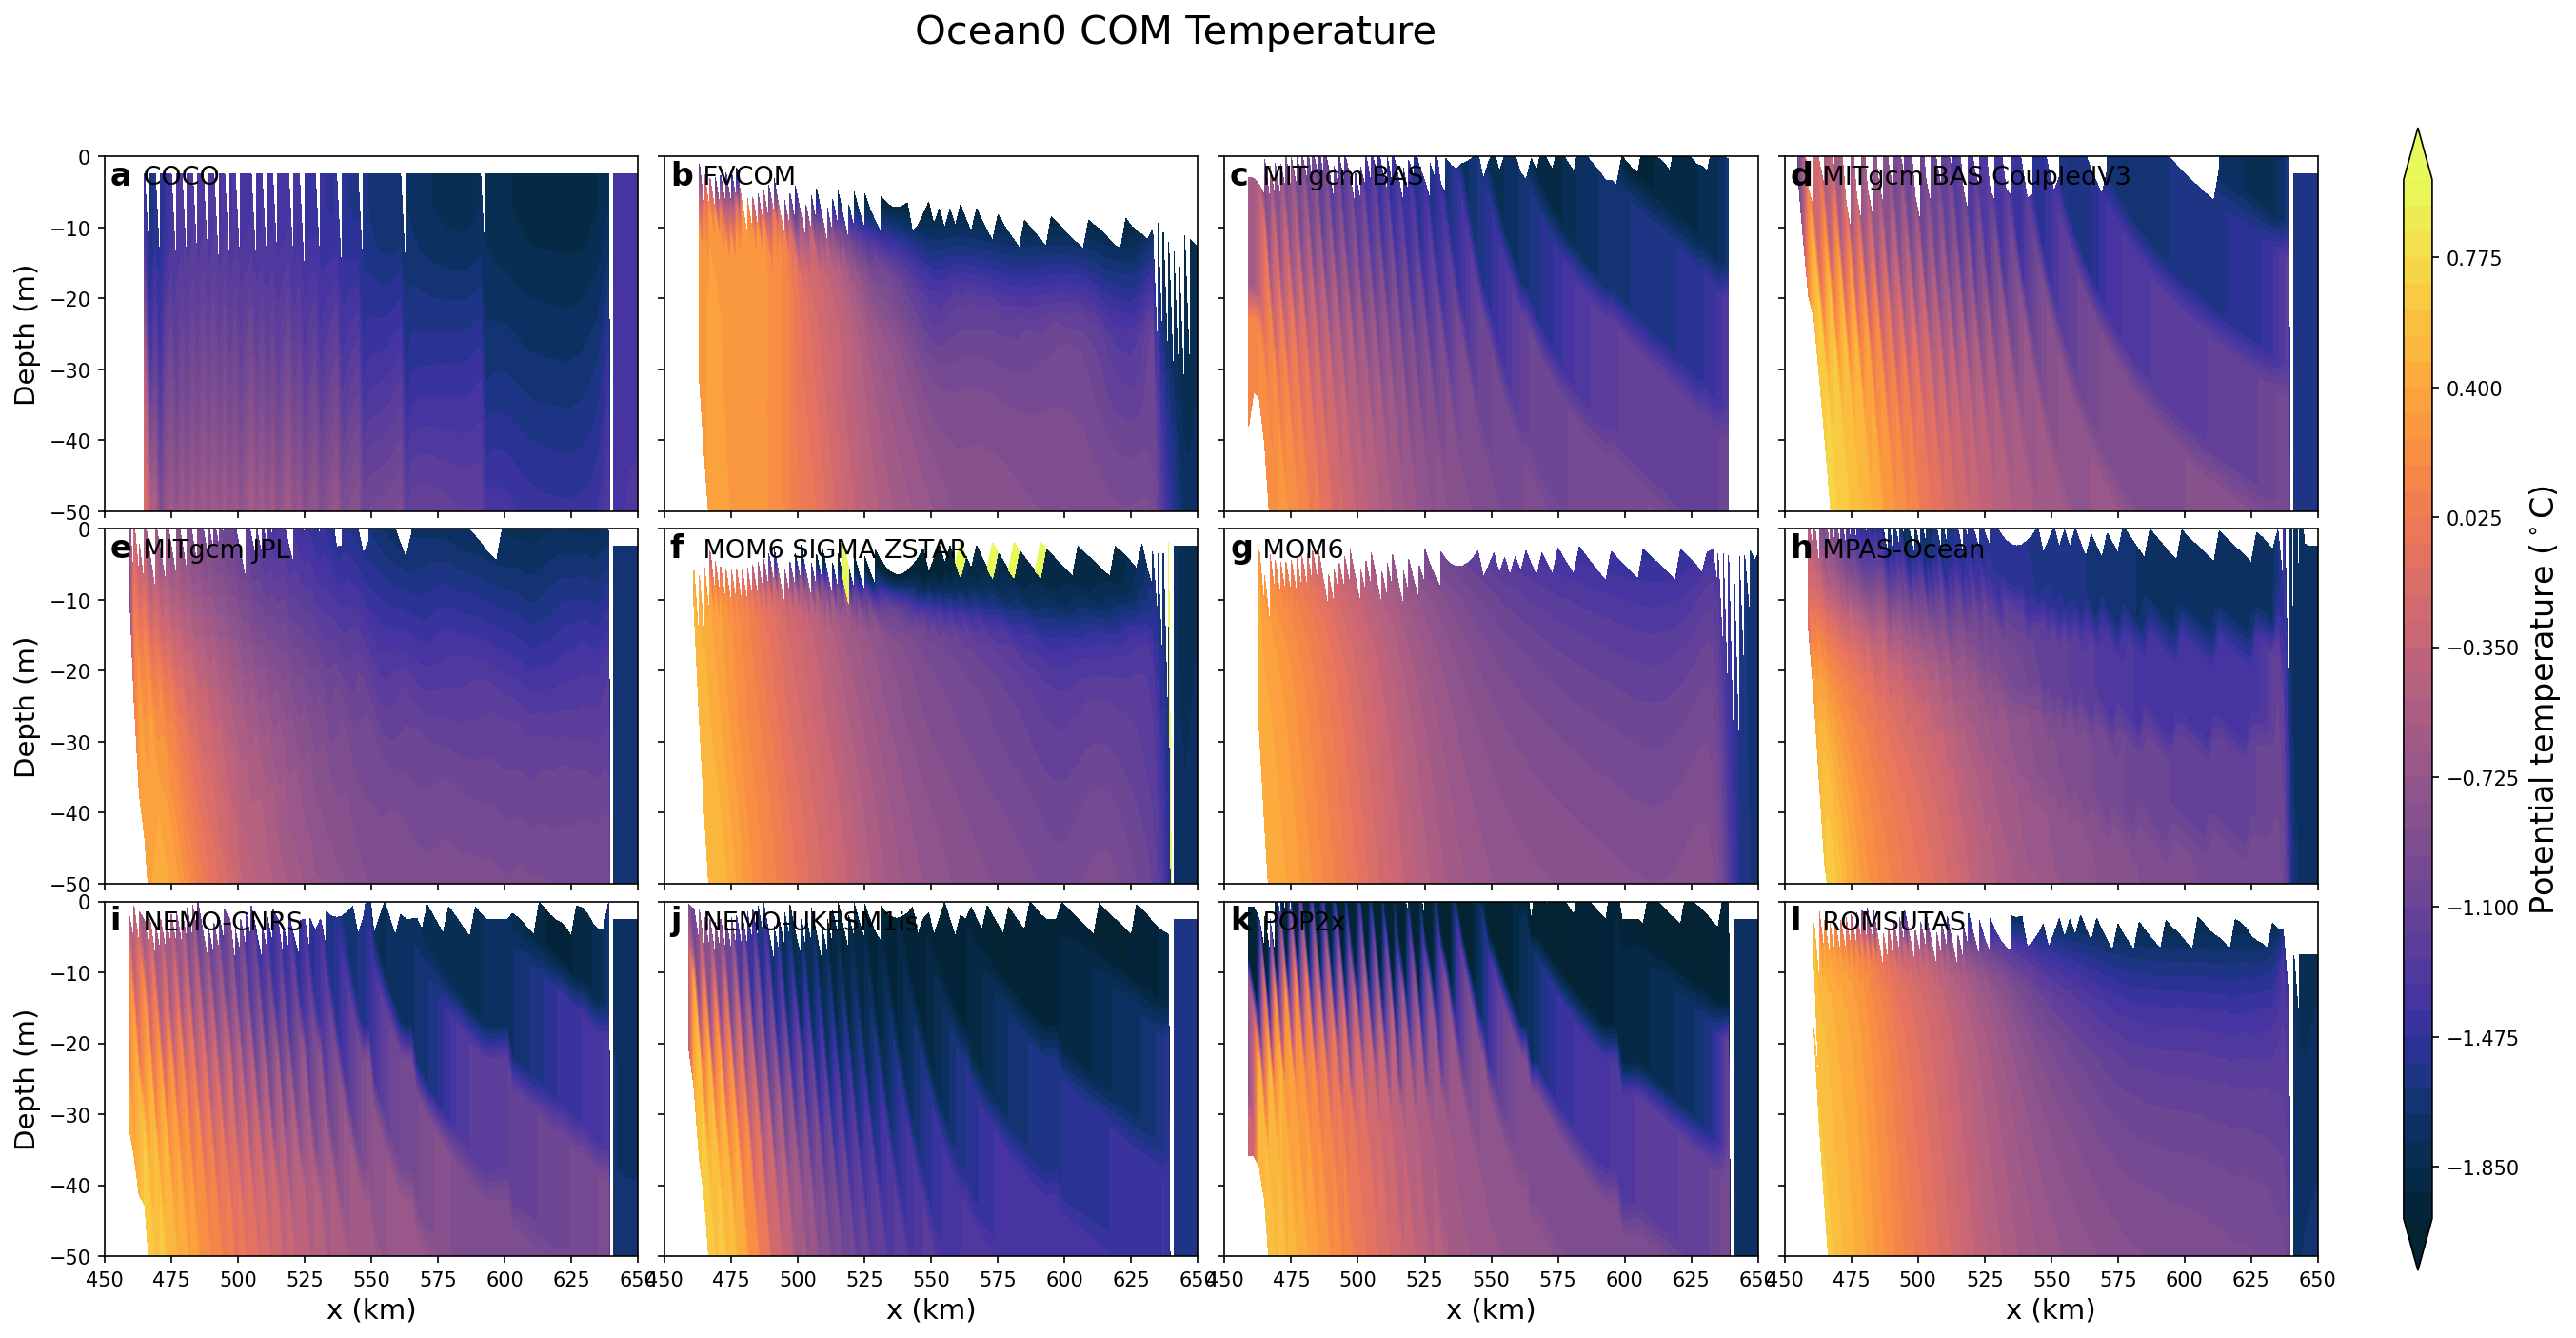

In [118]:
import matplotlib.gridspec as gridspec

expt = Ocean0_COM
labels = []
for fileIndex in range(len(expt)):
    fileName = expt[fileIndex]
    baseName = os.path.basename(basedrive +fileName)
    modelName = ' '.join(baseName.split('_')[2:]).split('.')[0]
    labels.append(modelName)
length = len(expt)
alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m']
ncols = int(np.ceil(length/3))

gs = gridspec.GridSpec(nrows=3,ncols=ncols,wspace=0.05, hspace=0.05)
fig = plt.figure(figsize=(20,10),facecolor='w',dpi = 150)


time = 12
for i in np.arange(length):
    # ax = plt.subplot(3,nrows,i+1)
    ax=fig.add_subplot(gs[i])
    data = xr.open_dataset(basedrive+expt[i], decode_times=False)
    var = data.temperatureXZ.isel(nTime = np.arange(time-13,time)).mean('nTime')
    # last year of time
    var['nz'] = var.nz*5+2.5 # add depth (2.5,7.5 etc)
    var['nx'] = var.nx*2+321
    # find ice draft for this transect
    iceDraft = data.iceDraft.isel(ny=20)
    try:
        iceDraft = iceDraft.isel(nTime = np.arange(time-13,time)).mean('nTime')
        print('removing time dimension from '+labels[i]+' ice draft')
    except ValueError:
        print('no time dimension in ',labels[i],' ice draft')
        
    print('CHECK is this the correct transect location?')
    #some models have a flipped iceDraft...
    if iceDraft.isel(nx=100)>0:
        iceDraft = -iceDraft
        print('This model ',expt[i],' has an inverted iceDraft - flipping to match others')

    #reshape to be 2d field
    iceDraft = np.tile(iceDraft,(len(var.nz),1))
    # make proper transect x,z locations
    NZ = (np.tile(var.nz.values,[len(var.nx),1])).T
    NX = (np.tile(var.nx.values,[len(var.nz),1]))
    # mr<1e36 is to get rid of NaNs.
    #c = (var.where(var <1e36)).plot.contourf(cmap = cm.cm.thermal, levels = np.linspace(-2,1,41),extend = 'both',add_colorbar = False)#, cbar_kwargs = {'label':'Overturning \n Streamfunction (Sv)'},extend = 'both')
    c = plt.contourf(NX,-(NZ+iceDraft),(var.where(var <1e36)),cmap = cm.cm.thermal, levels = np.linspace(-2,1,41),extend = 'both')
    # ls = (var.where(var <1e36)).plot.contour( levels = np.linspace(-2,1,21), colors = 'k', linewidths = 0.4)
    plt.text(0.01,0.99,alphabet[i], fontsize = 16, transform=ax.transAxes, fontweight='bold', va='top')
    plt.text(0.01,0.975,'    '+labels[i], fontsize = 13, transform=ax.transAxes, va='top')
    # ax.grid()

    if (i==1) or (i==2) or (i==3) or (i==5) or (i==6) or (i==7) or (i==9) or (i==10) or (i==11):
        ax.set_yticklabels([])
    if (i<8):
        ax.set_xticklabels([])
        
    if (i==0) or (i==4) or (i==8):
        plt.ylabel('Depth (m)',fontsize=14)
    else:
        plt.ylabel('')
    if i>=8:
        plt.xlabel('x (km)',fontsize=14)
    else:
        plt.xlabel('')
    plt.ylim(-50,0)
    plt.xlim(450,650)


cax = plt.axes([0.93,0.1,0.01,0.8])
cbar = plt.colorbar(c, cax = cax)
cbar.ax.set_ylabel(r'Potential temperature ($^\circ $C)', fontsize = 16)
# cbar.add_lines(ls)

fig.suptitle('Ocean0 COM Temperature', fontsize = 20);

no time dimension in  COCO  ice draft
CHECK is this the correct transect location?
removing time dimension from FVCOM ice draft
CHECK is this the correct transect location?
no time dimension in  MITgcm BAS  ice draft
CHECK is this the correct transect location?
no time dimension in  MITgcm BAS CoupledV3  ice draft
CHECK is this the correct transect location?
no time dimension in  MITgcm JPL  ice draft
CHECK is this the correct transect location?
no time dimension in  MOM6 SIGMA ZSTAR  ice draft
CHECK is this the correct transect location?
no time dimension in  MOM6  ice draft
CHECK is this the correct transect location?
no time dimension in  MPAS-Ocean  ice draft
CHECK is this the correct transect location?
no time dimension in  NEMO-CNRS  ice draft
CHECK is this the correct transect location?
This model  NEMO-CNRS/Ocean0-2 COM/Ocean1_COM_NEMO-CNRS.nc  has an inverted iceDraft - flipping to match others
no time dimension in  NEMO-UKESM1is  ice draft
CHECK is this the correct transect l

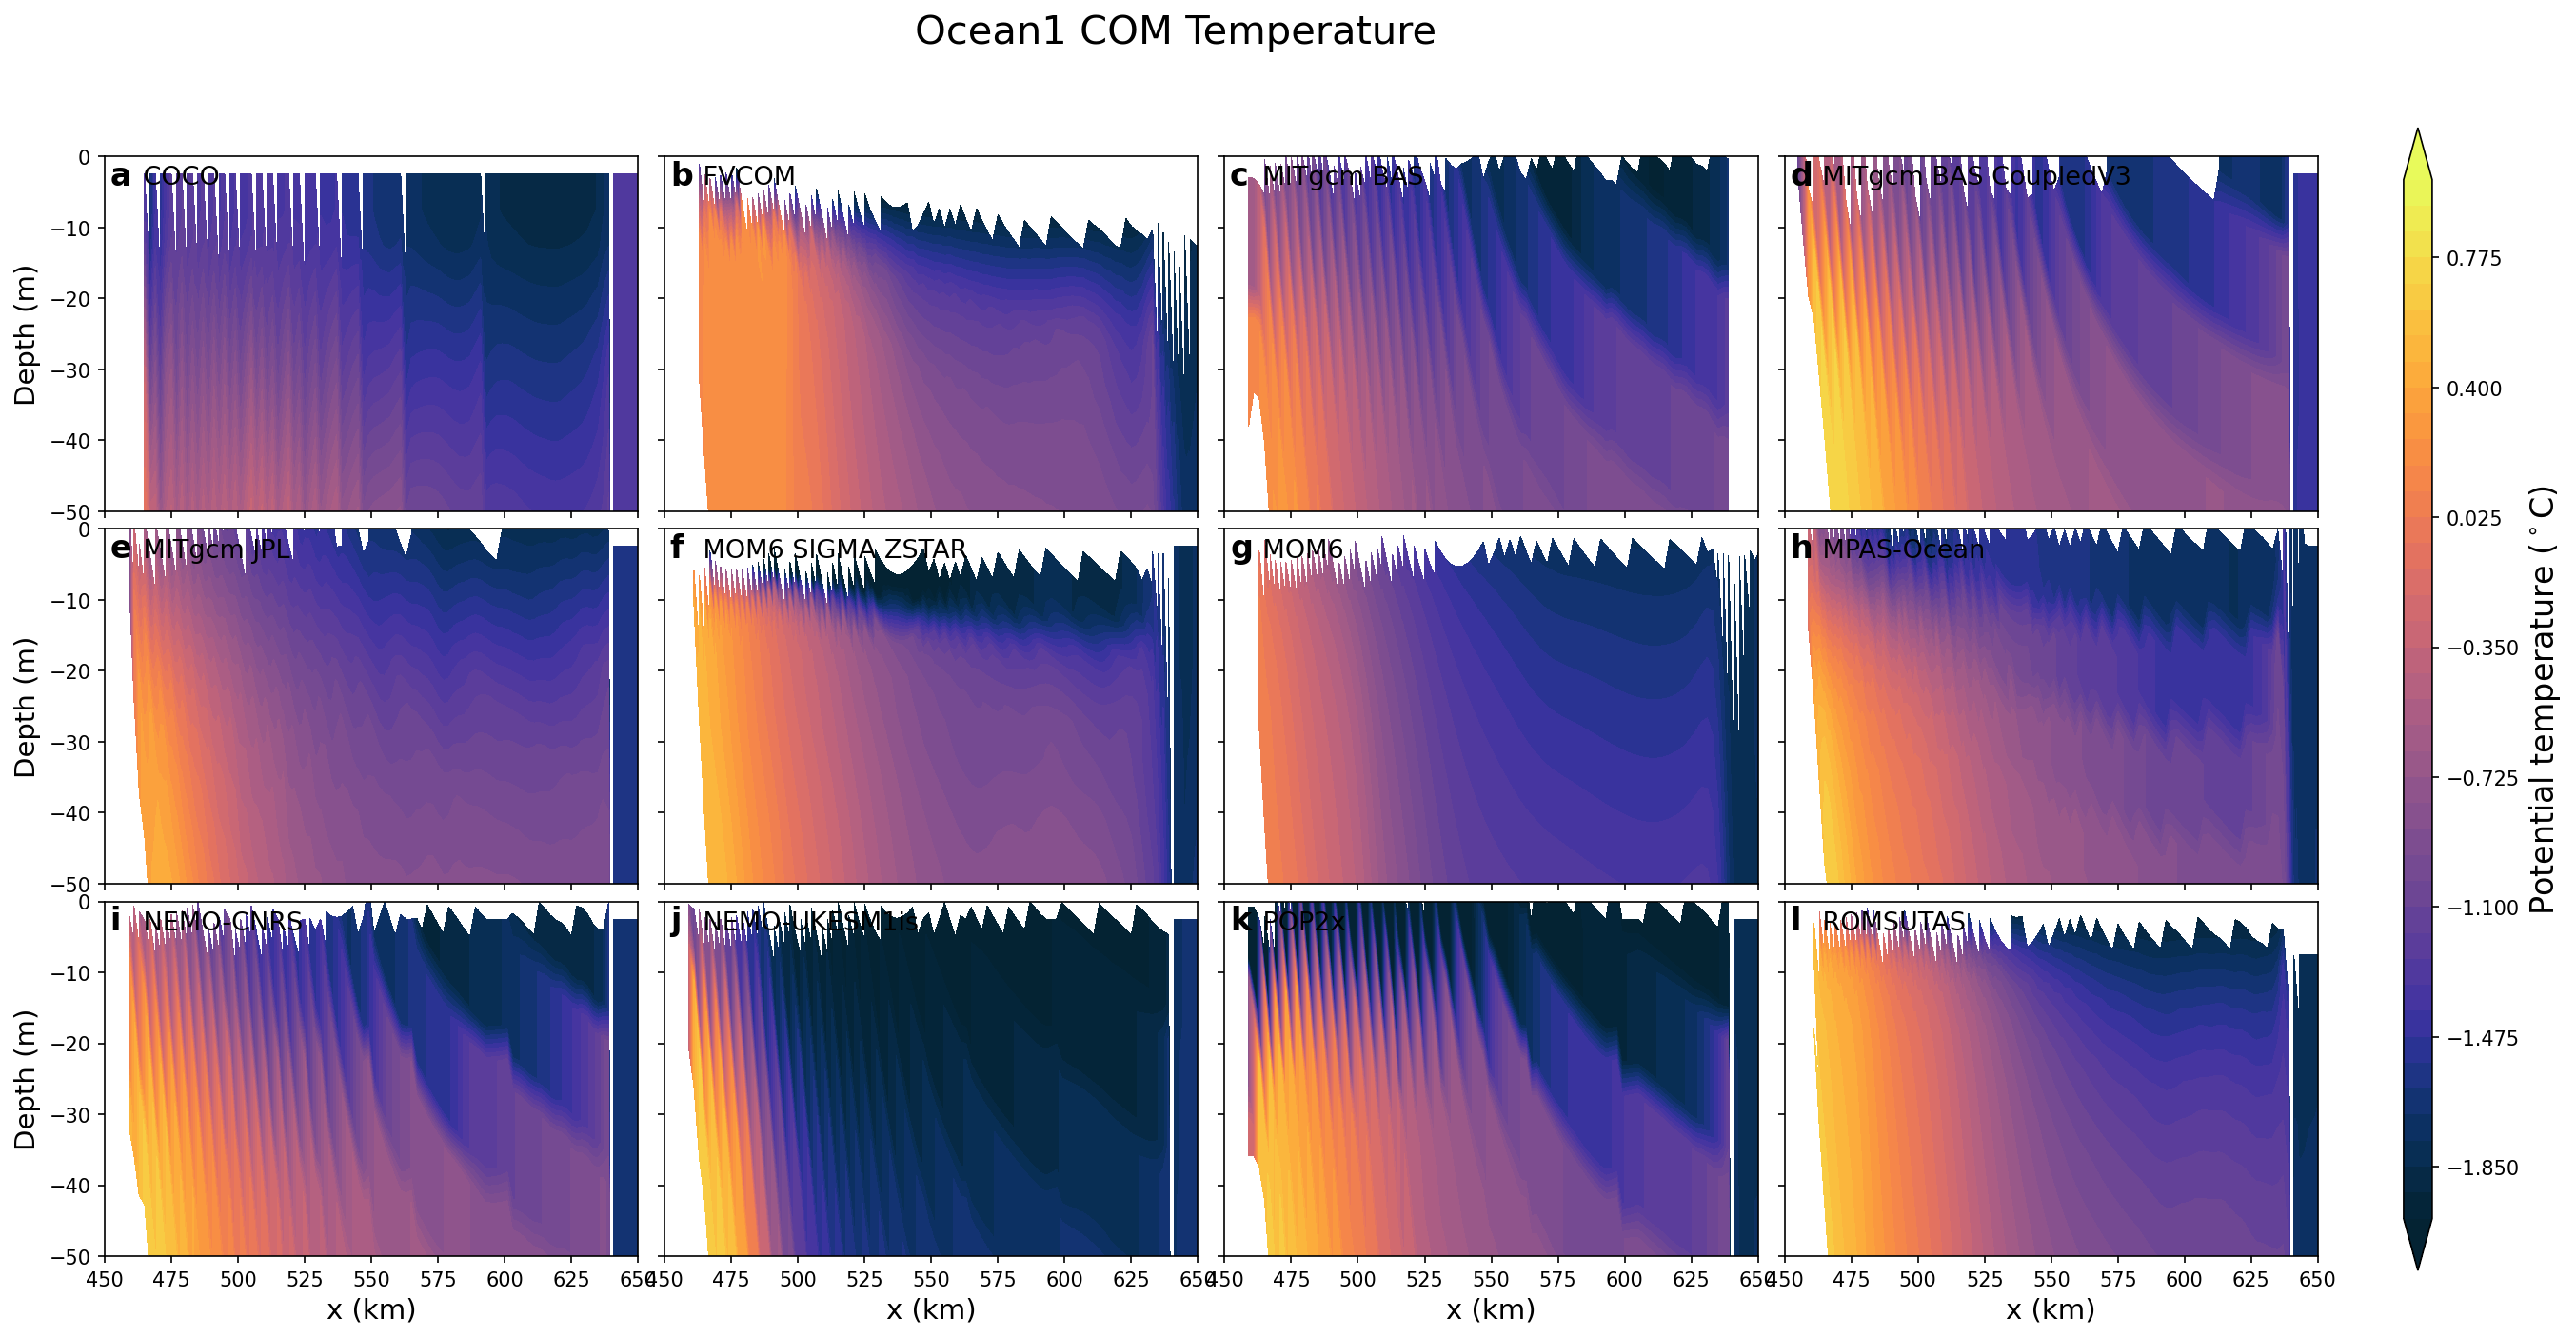

In [152]:
import matplotlib.gridspec as gridspec

expt = Ocean1_COM
labels = []
for fileIndex in range(len(expt)):
    fileName = expt[fileIndex]
    baseName = os.path.basename(basedrive +fileName)
    modelName = ' '.join(baseName.split('_')[2:]).split('.')[0]
    labels.append(modelName)
length = len(expt)
alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m']
ncols = int(np.ceil(length/3))

gs = gridspec.GridSpec(nrows=3,ncols=ncols,wspace=0.05, hspace=0.05)
fig = plt.figure(figsize=(20,10),facecolor='w',dpi = 150)


time = 240 #NOTE TO REMEMBER TO CHANGE THIS!!
for i in np.arange(length):
    # ax = plt.subplot(3,nrows,i+1)
    ax=fig.add_subplot(gs[i])
    data = xr.open_dataset(basedrive+expt[i], decode_times=False)
    var = data.temperatureXZ.isel(nTime = np.arange(time-13,time)).mean('nTime')
    # last year of time
    var['nz'] = var.nz*5+2.5 # add depth (2.5,7.5 etc)
    var['nx'] = var.nx*2+321
    # find ice draft for this transect
    iceDraft = data.iceDraft.isel(ny=20)
    try:
        iceDraft = iceDraft.isel(nTime = np.arange(time-13,time)).mean('nTime')
        print('removing time dimension from '+labels[i]+' ice draft')
    except ValueError:
        print('no time dimension in ',labels[i],' ice draft')
        
    print('CHECK is this the correct transect location?')
    #some models have a flipped iceDraft...
    if iceDraft.isel(nx=100)>0:
        iceDraft = -iceDraft
        print('This model ',expt[i],' has an inverted iceDraft - flipping to match others')

    #reshape to be 2d field
    iceDraft = np.tile(iceDraft,(len(var.nz),1))
    # make proper transect x,z locations
    NZ = (np.tile(var.nz.values,[len(var.nx),1])).T
    NX = (np.tile(var.nx.values,[len(var.nz),1]))
    # mr<1e36 is to get rid of NaNs.
    #c = (var.where(var <1e36)).plot.contourf(cmap = cm.cm.thermal, levels = np.linspace(-2,1,41),extend = 'both',add_colorbar = False)#, cbar_kwargs = {'label':'Overturning \n Streamfunction (Sv)'},extend = 'both')
    c = plt.contourf(NX,-(NZ+iceDraft),(var.where(var <1e36)),cmap = cm.cm.thermal, levels = np.linspace(-2,1,41),extend = 'both')
    # ls = (var.where(var <1e36)).plot.contour( levels = np.linspace(-2,1,21), colors = 'k', linewidths = 0.4)
    plt.text(0.01,0.99,alphabet[i], fontsize = 16, transform=ax.transAxes, fontweight='bold', va='top')
    plt.text(0.01,0.975,'    '+labels[i], fontsize = 13, transform=ax.transAxes, va='top')
    # ax.grid()

    if (i==1) or (i==2) or (i==3) or (i==5) or (i==6) or (i==7) or (i==9) or (i==10) or (i==11):
        ax.set_yticklabels([])
    if (i<8):
        ax.set_xticklabels([])
        
    if (i==0) or (i==4) or (i==8):
        plt.ylabel('Depth (m)',fontsize=14)
    else:
        plt.ylabel('')
    if i>=8:
        plt.xlabel('x (km)',fontsize=14)
    else:
        plt.xlabel('')
    plt.ylim(-50,0)
    plt.xlim(450,650)


cax = plt.axes([0.93,0.1,0.01,0.8])
cbar = plt.colorbar(c, cax = cax)
cbar.ax.set_ylabel(r'Potential temperature ($^\circ $C)', fontsize = 16)
# cbar.add_lines(ls)

fig.suptitle('Ocean1 COM Temperature', fontsize = 20);

no time dimension in  COCO  ice draft
CHECK is this the correct transect location?
removing time dimension from FVCOM ice draft
CHECK is this the correct transect location?
no time dimension in  MITgcm BAS  ice draft
CHECK is this the correct transect location?
no time dimension in  MITgcm BAS CoupledV3  ice draft
CHECK is this the correct transect location?
no time dimension in  MITgcm JPL  ice draft
CHECK is this the correct transect location?
no time dimension in  MOM6 SIGMA ZSTAR  ice draft
CHECK is this the correct transect location?
no time dimension in  MOM6  ice draft
CHECK is this the correct transect location?
no time dimension in  MPAS-Ocean  ice draft
CHECK is this the correct transect location?
no time dimension in  NEMO-CNRS  ice draft
CHECK is this the correct transect location?
This model  NEMO-CNRS/Ocean0-2 COM/Ocean1_COM_NEMO-CNRS.nc  has an inverted iceDraft - flipping to match others
no time dimension in  NEMO-UKESM1is  ice draft
CHECK is this the correct transect l

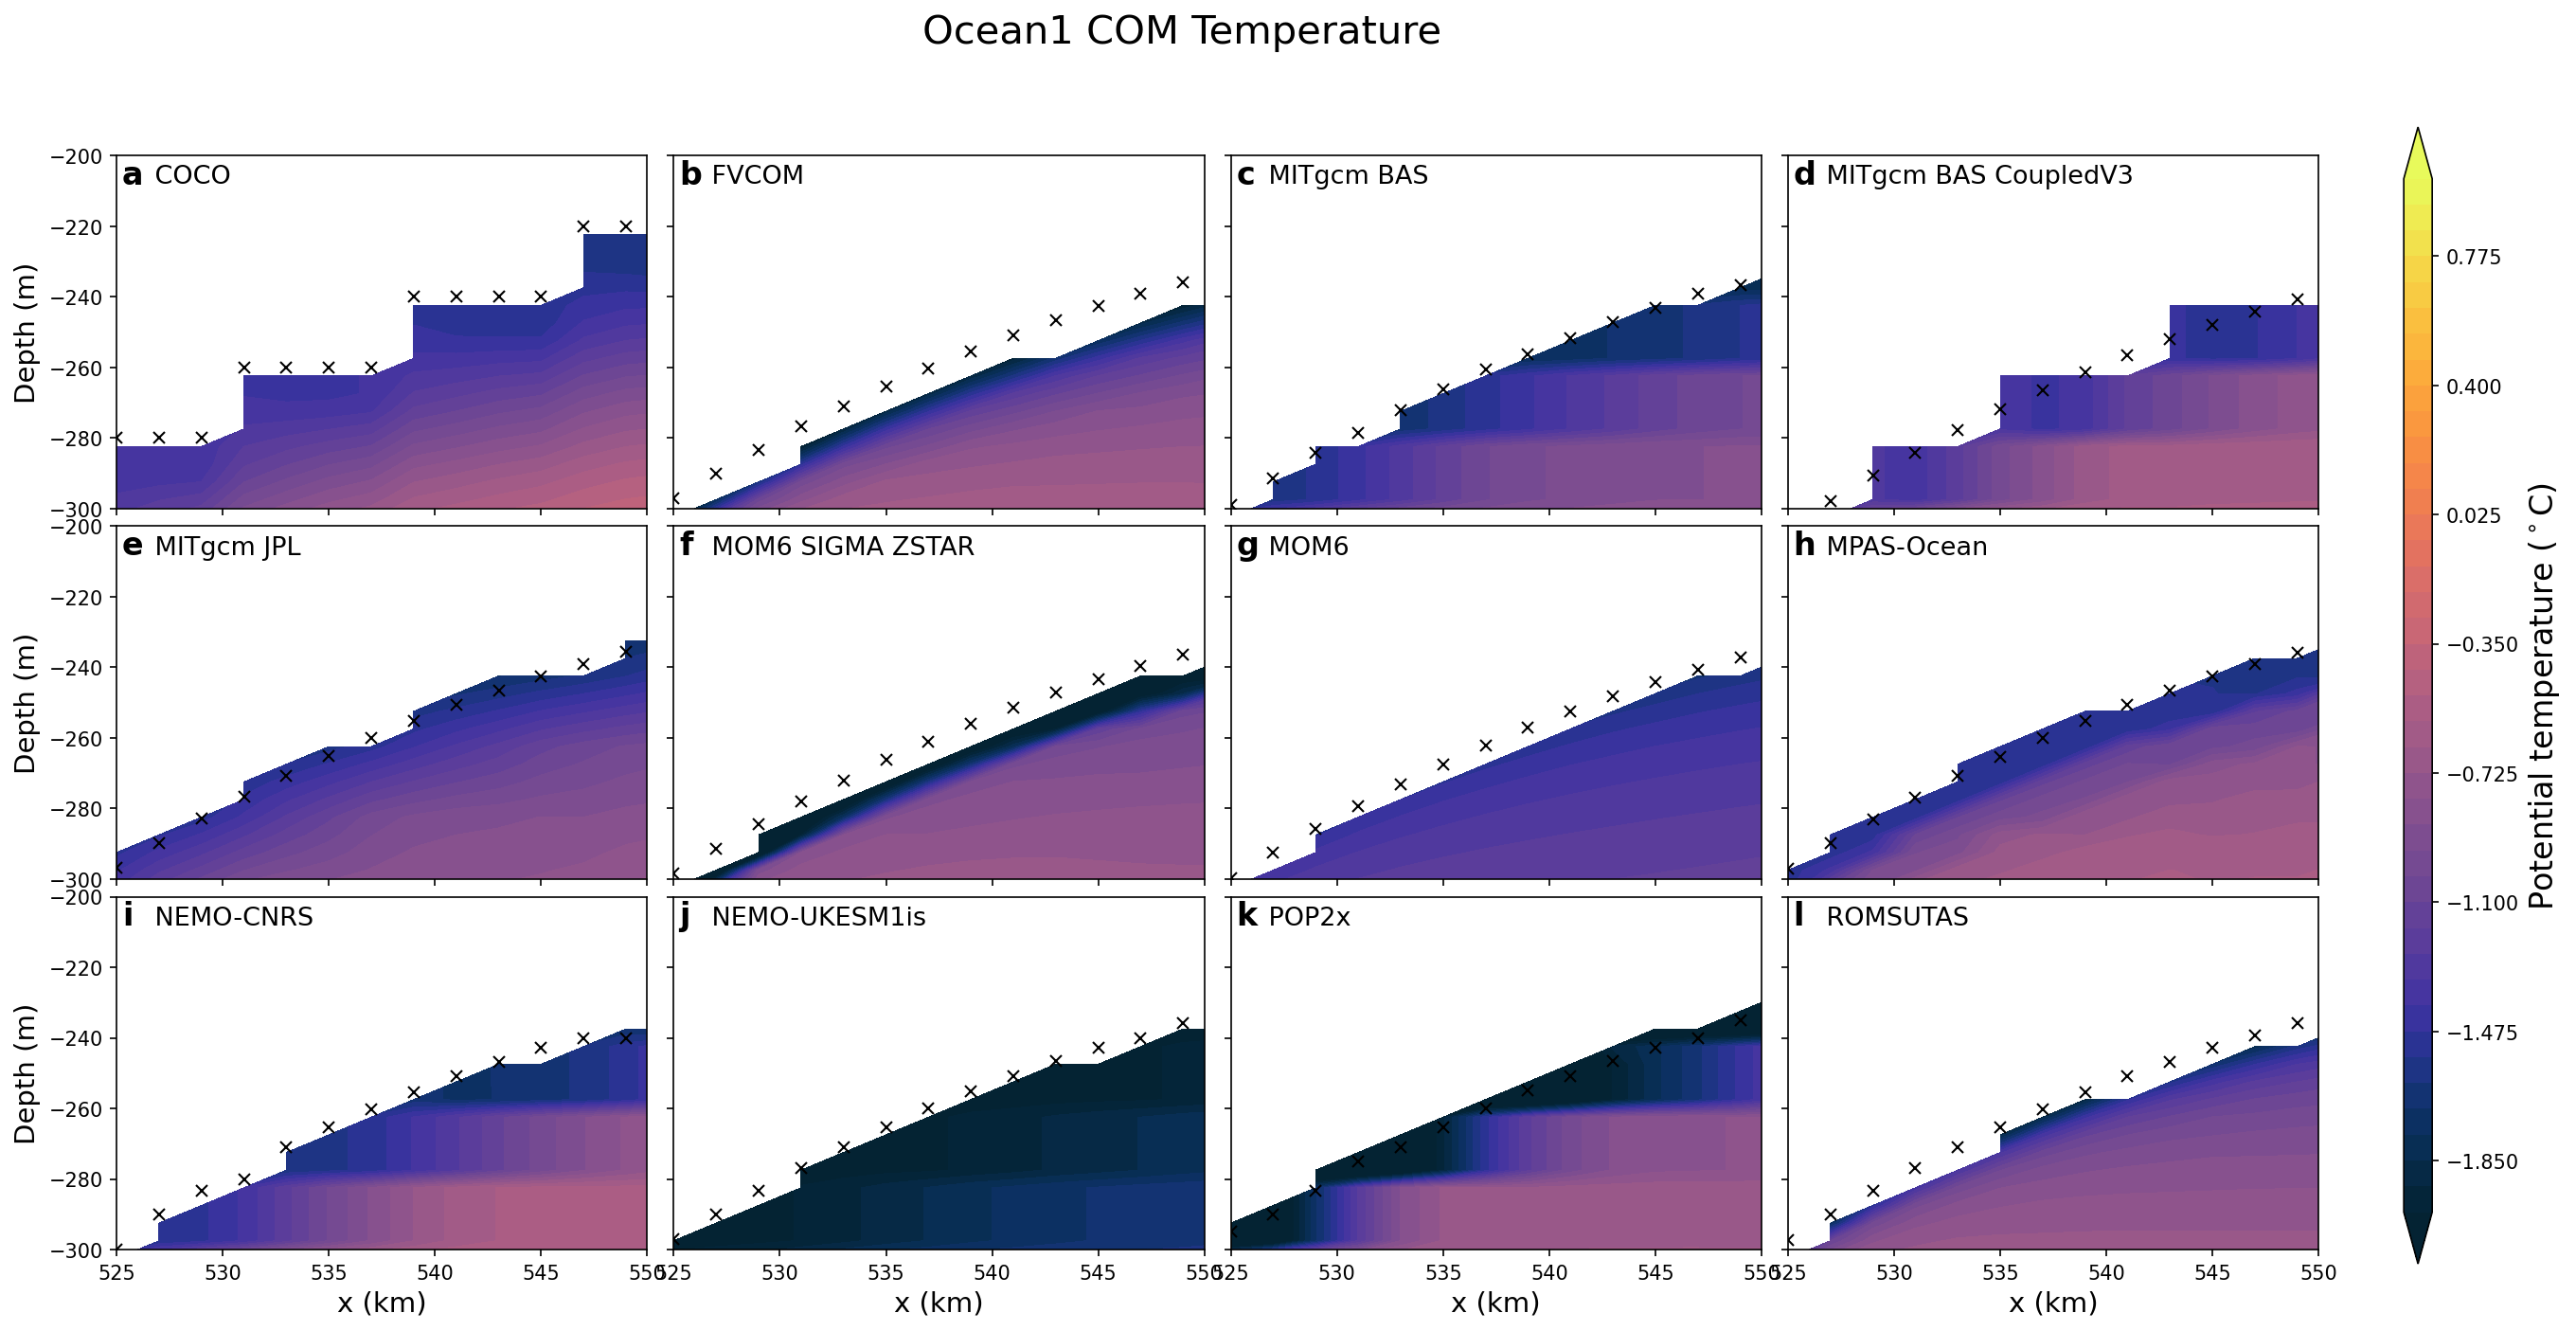

In [181]:
import matplotlib.gridspec as gridspec

expt = Ocean1_COM
labels = []
for fileIndex in range(len(expt)):
    fileName = expt[fileIndex]
    baseName = os.path.basename(basedrive +fileName)
    modelName = ' '.join(baseName.split('_')[2:]).split('.')[0]
    labels.append(modelName)
length = len(expt)
alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m']
ncols = int(np.ceil(length/3))

gs = gridspec.GridSpec(nrows=3,ncols=ncols,wspace=0.05, hspace=0.05)
fig = plt.figure(figsize=(20,10),facecolor='w',dpi = 150)


time = 240 #NOTE TO REMEMBER TO CHANGE THIS!!
for i in np.arange(length):
    # ax = plt.subplot(3,nrows,i+1)
    ax=fig.add_subplot(gs[i])
    data = xr.open_dataset(basedrive+expt[i], decode_times=False)
    var = data.temperatureXZ.isel(nTime = np.arange(time-13,time)).mean('nTime')
    # last year of time
    var['nz'] = var.nz*5+2.5 # add depth (2.5,7.5 etc)
    var['nx'] = var.nx*2+321
    # find ice draft for this transect
    iceDraft = data.iceDraft.isel(ny=20)
    try:
        iceDraft = iceDraft.isel(nTime = np.arange(time-13,time)).mean('nTime')
        print('removing time dimension from '+labels[i]+' ice draft')
    except ValueError:
        print('no time dimension in ',labels[i],' ice draft')
        
    print('CHECK is this the correct transect location?')
    #some models have a flipped iceDraft...
    if iceDraft.isel(nx=100)>0:
        iceDraft = -iceDraft
        print('This model ',expt[i],' has an inverted iceDraft - flipping to match others')

    #reshape to be 2d field
    iceDraft = np.tile(iceDraft,(len(var.nz),1))
    # make proper transect x,z locations
    NZ = (np.tile(var.nz.values,[len(var.nx),1])).T
    NX = (np.tile(var.nx.values,[len(var.nz),1]))
    # mr<1e36 is to get rid of NaNs.
    #c = (var.where(var <1e36)).plot.contourf(cmap = cm.cm.thermal, levels = np.linspace(-2,1,41),extend = 'both',add_colorbar = False)#, cbar_kwargs = {'label':'Overturning \n Streamfunction (Sv)'},extend = 'both')
    c = plt.contourf(NX,-(NZ),(var.where(var <1e36)),cmap = cm.cm.thermal, levels = np.linspace(-2,1,41),extend = 'both')
    # ls = (var.where(var <1e36)).plot.contour( levels = np.linspace(-2,1,21), colors = 'k', linewidths = 0.4)
    poi = plt.plot(NX[0,:],iceDraft[0,:],'kx')
    plt.text(0.01,0.99,alphabet[i], fontsize = 16, transform=ax.transAxes, fontweight='bold', va='top')
    plt.text(0.01,0.975,'    '+labels[i], fontsize = 13, transform=ax.transAxes, va='top')
    # ax.grid()

    if (i==1) or (i==2) or (i==3) or (i==5) or (i==6) or (i==7) or (i==9) or (i==10) or (i==11):
        ax.set_yticklabels([])
    if (i<8):
        ax.set_xticklabels([])
        
    if (i==0) or (i==4) or (i==8):
        plt.ylabel('Depth (m)',fontsize=14)
    else:
        plt.ylabel('')
    if i>=8:
        plt.xlabel('x (km)',fontsize=14)
    else:
        plt.xlabel('')
    plt.ylim(-300,-200)
    plt.xlim(525,550)


cax = plt.axes([0.93,0.1,0.01,0.8])
cbar = plt.colorbar(c, cax = cax)
cbar.ax.set_ylabel(r'Potential temperature ($^\circ $C)', fontsize = 16)
# cbar.add_lines(ls)

fig.suptitle('Ocean1 COM Temperature', fontsize = 20);

no time dimension in  COCO  ice draft
CHECK is this the correct transect location?
removing time dimension from FVCOM ice draft
CHECK is this the correct transect location?
no time dimension in  MITgcm BAS  ice draft
CHECK is this the correct transect location?
no time dimension in  MITgcm BAS CoupledV3  ice draft
CHECK is this the correct transect location?
no time dimension in  MITgcm JPL  ice draft
CHECK is this the correct transect location?
no time dimension in  MOM6 SIGMA ZSTAR  ice draft
CHECK is this the correct transect location?
no time dimension in  MOM6  ice draft
CHECK is this the correct transect location?
no time dimension in  MPAS-Ocean  ice draft
CHECK is this the correct transect location?
no time dimension in  NEMO-CNRS  ice draft
CHECK is this the correct transect location?
This model  NEMO-CNRS/Ocean0-2 COM/Ocean2_COM_NEMO-CNRS.nc  has an inverted iceDraft - flipping to match others
no time dimension in  NEMO-UKESM1is  ice draft
CHECK is this the correct transect l

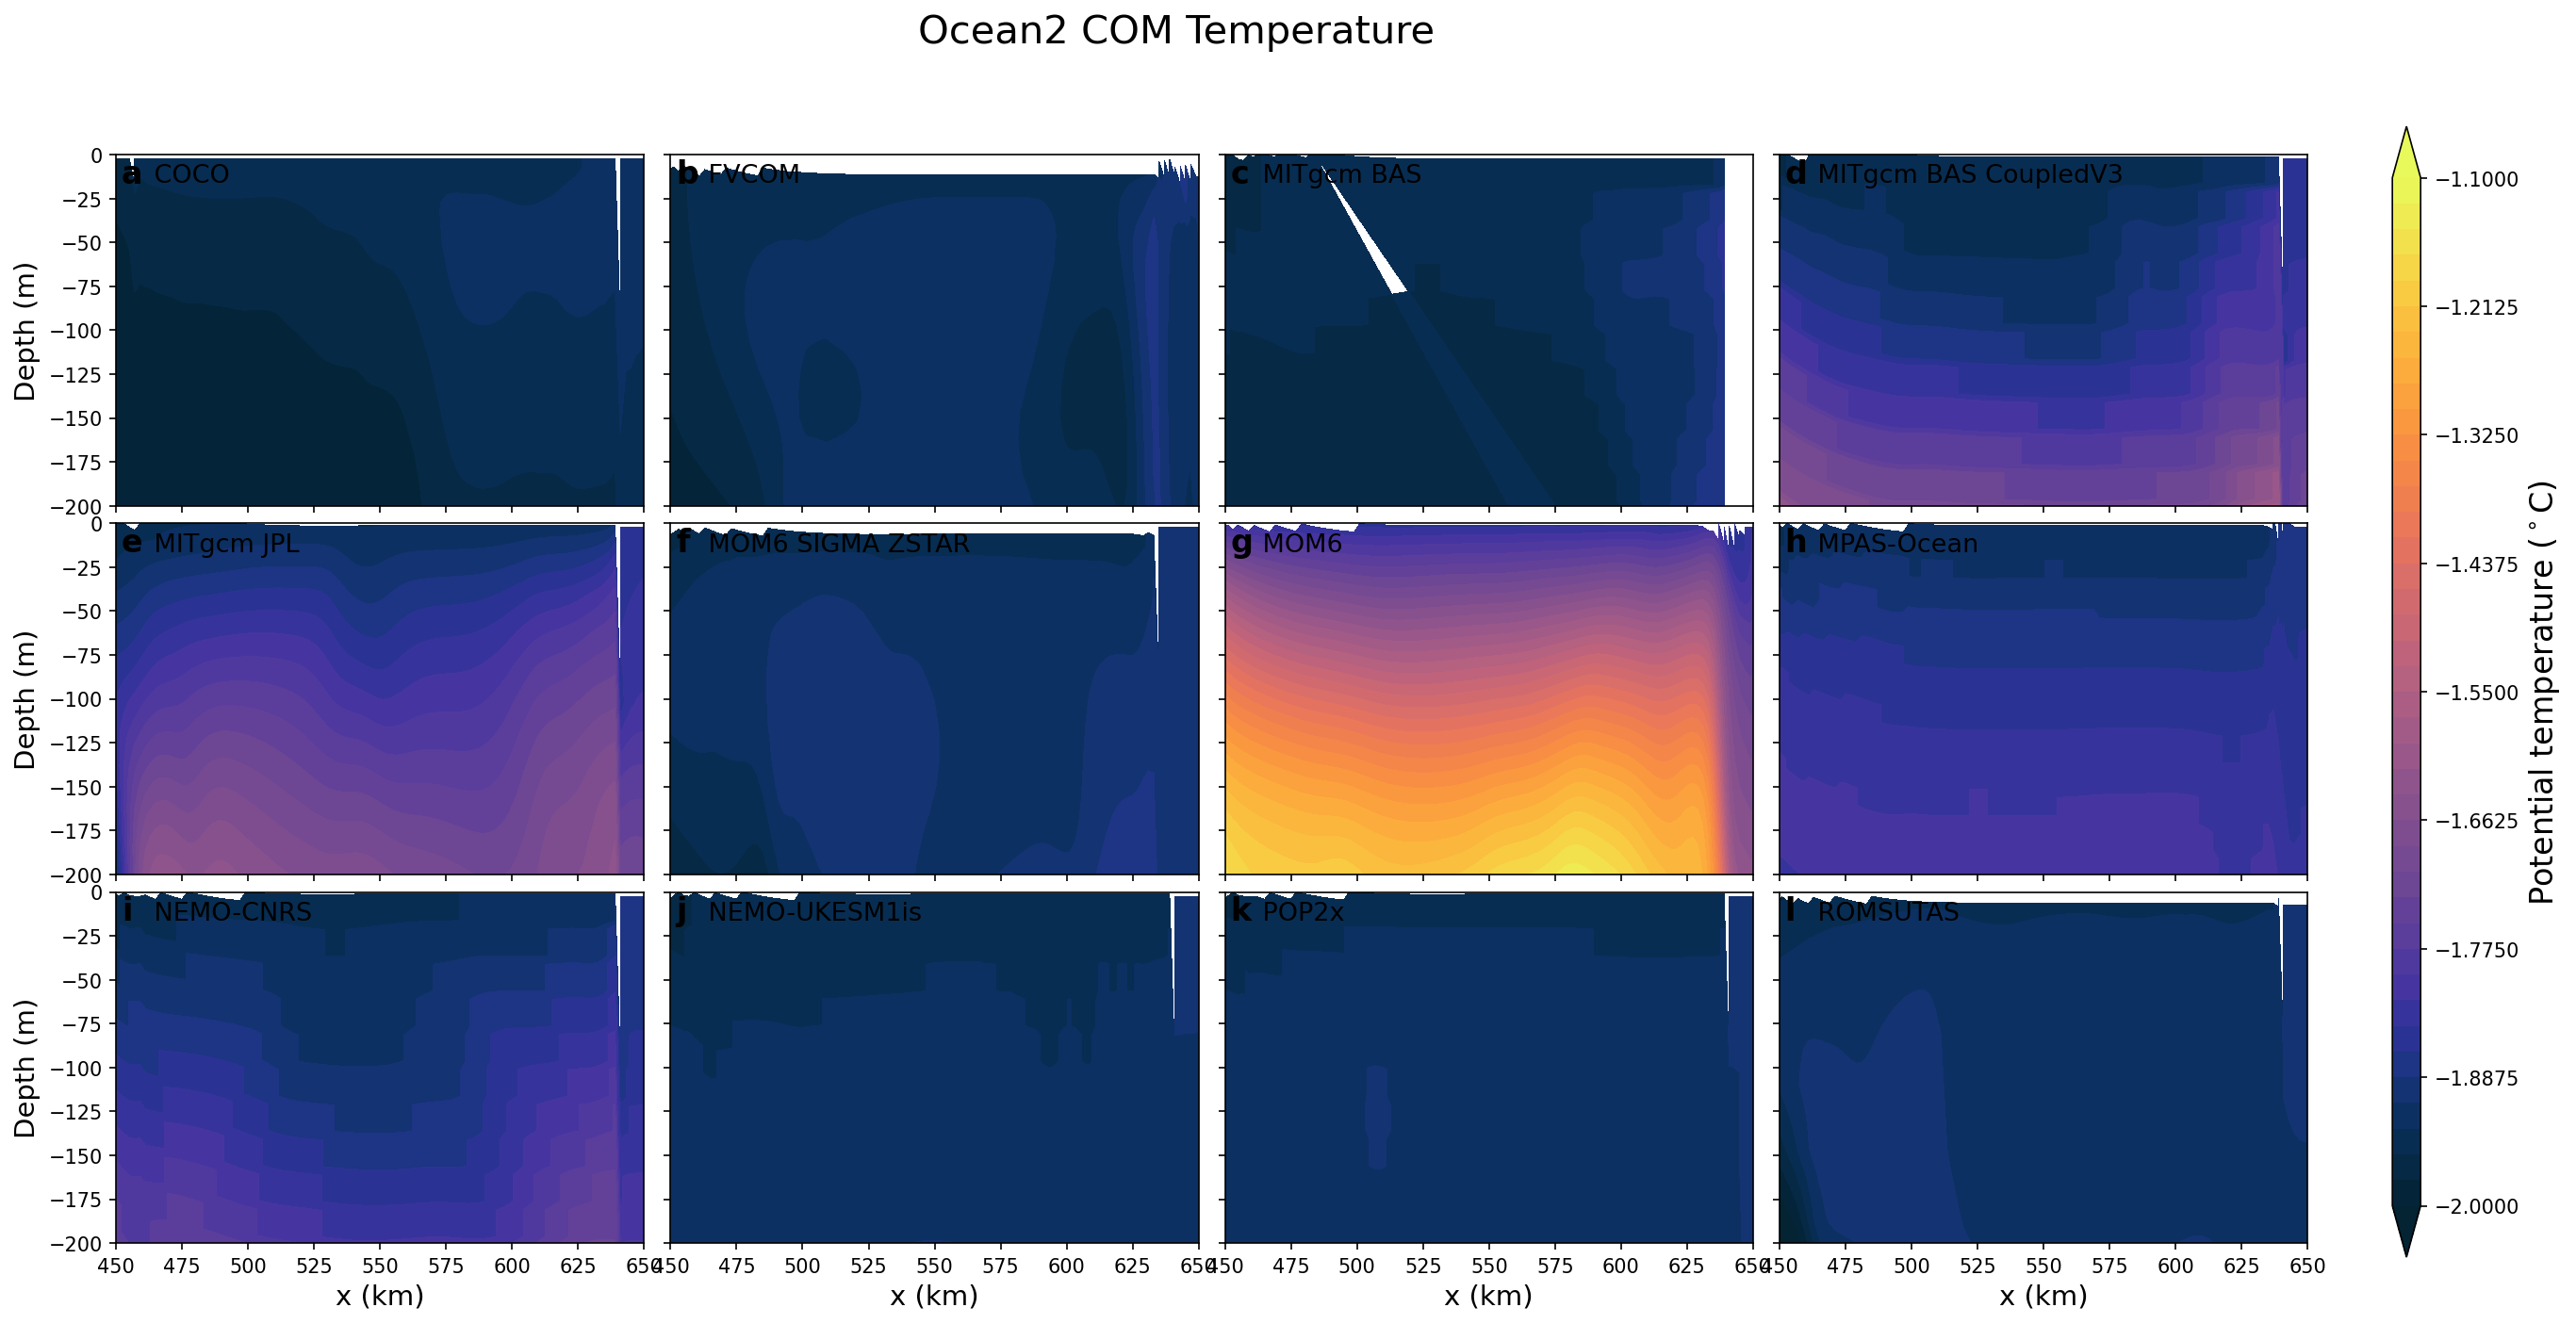

In [151]:
import matplotlib.gridspec as gridspec

expt = Ocean2_COM
labels = []
for fileIndex in range(len(expt)):
    fileName = expt[fileIndex]
    baseName = os.path.basename(basedrive +fileName)
    modelName = ' '.join(baseName.split('_')[2:]).split('.')[0]
    labels.append(modelName)
length = len(expt)
alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m']
ncols = int(np.ceil(length/3))

gs = gridspec.GridSpec(nrows=3,ncols=ncols,wspace=0.05, hspace=0.05)
fig = plt.figure(figsize=(20,10),facecolor='w',dpi = 150)


time = 240 #NOTE TO REMEMBER TO CHANGE THIS!!
for i in np.arange(length):
    # ax = plt.subplot(3,nrows,i+1)
    ax=fig.add_subplot(gs[i])
    data = xr.open_dataset(basedrive+expt[i], decode_times=False)
    var = data.temperatureXZ.isel(nTime = np.arange(time-13,time)).mean('nTime')
    # last year of time
    var['nz'] = var.nz*5+2.5 # add depth (2.5,7.5 etc)
    var['nx'] = var.nx*2+321
    # find ice draft for this transect
    iceDraft = data.iceDraft.isel(ny=20)
    try:
        iceDraft = iceDraft.isel(nTime = np.arange(time-13,time)).mean('nTime')
        print('removing time dimension from '+labels[i]+' ice draft')
    except ValueError:
        print('no time dimension in ',labels[i],' ice draft')
        
    print('CHECK is this the correct transect location?')
    #some models have a flipped iceDraft...
    if iceDraft.isel(nx=100)>0:
        iceDraft = -iceDraft
        print('This model ',expt[i],' has an inverted iceDraft - flipping to match others')

    #reshape to be 2d field
    iceDraft = np.tile(iceDraft,(len(var.nz),1))
    # make proper transect x,z locations
    NZ = (np.tile(var.nz.values,[len(var.nx),1])).T
    NX = (np.tile(var.nx.values,[len(var.nz),1]))
    # mr<1e36 is to get rid of NaNs.
    #c = (var.where(var <1e36)).plot.contourf(cmap = cm.cm.thermal, levels = np.linspace(-2,1,41),extend = 'both',add_colorbar = False)#, cbar_kwargs = {'label':'Overturning \n Streamfunction (Sv)'},extend = 'both')
    c = plt.contourf(NX,-(NZ+iceDraft),(var.where(var <1e36)),cmap = cm.cm.thermal, levels = np.linspace(-2,-1.1,41),extend = 'both')
    # ls = (var.where(var <1e36)).plot.contour( levels = np.linspace(-2,1,21), colors = 'k', linewidths = 0.4)
    plt.text(0.01,0.99,alphabet[i], fontsize = 16, transform=ax.transAxes, fontweight='bold', va='top')
    plt.text(0.01,0.975,'    '+labels[i], fontsize = 13, transform=ax.transAxes, va='top')
    # ax.grid()

    if (i==1) or (i==2) or (i==3) or (i==5) or (i==6) or (i==7) or (i==9) or (i==10) or (i==11):
        ax.set_yticklabels([])
    if (i<8):
        ax.set_xticklabels([])
        
    if (i==0) or (i==4) or (i==8):
        plt.ylabel('Depth (m)',fontsize=14)
    else:
        plt.ylabel('')
    if i>=8:
        plt.xlabel('x (km)',fontsize=14)
    else:
        plt.xlabel('')
    plt.ylim(-200,0)
    plt.xlim(450,650)


cax = plt.axes([0.93,0.1,0.01,0.8])
cbar = plt.colorbar(c, cax = cax)
cbar.ax.set_ylabel(r'Potential temperature ($^\circ $C)', fontsize = 16)
# cbar.add_lines(ls)

fig.suptitle('Ocean2 COM Temperature', fontsize = 20);

no time dimension in  COCO  ice draft
CHECK is this the correct transect location?
removing time dimension from FVCOM ice draft
CHECK is this the correct transect location?
no time dimension in  MITgcm BAS  ice draft
CHECK is this the correct transect location?
no time dimension in  MITgcm BAS CoupledV3  ice draft
CHECK is this the correct transect location?
no time dimension in  MITgcm JPL  ice draft
CHECK is this the correct transect location?
no time dimension in  MOM6 SIGMA ZSTAR  ice draft
CHECK is this the correct transect location?
no time dimension in  MOM6  ice draft
CHECK is this the correct transect location?
no time dimension in  MPAS-Ocean  ice draft
CHECK is this the correct transect location?
no time dimension in  NEMO-CNRS  ice draft
CHECK is this the correct transect location?
This model  NEMO-CNRS/Ocean0-2 COM/Ocean2_COM_NEMO-CNRS.nc  has an inverted iceDraft - flipping to match others
no time dimension in  NEMO-UKESM1is  ice draft
CHECK is this the correct transect l

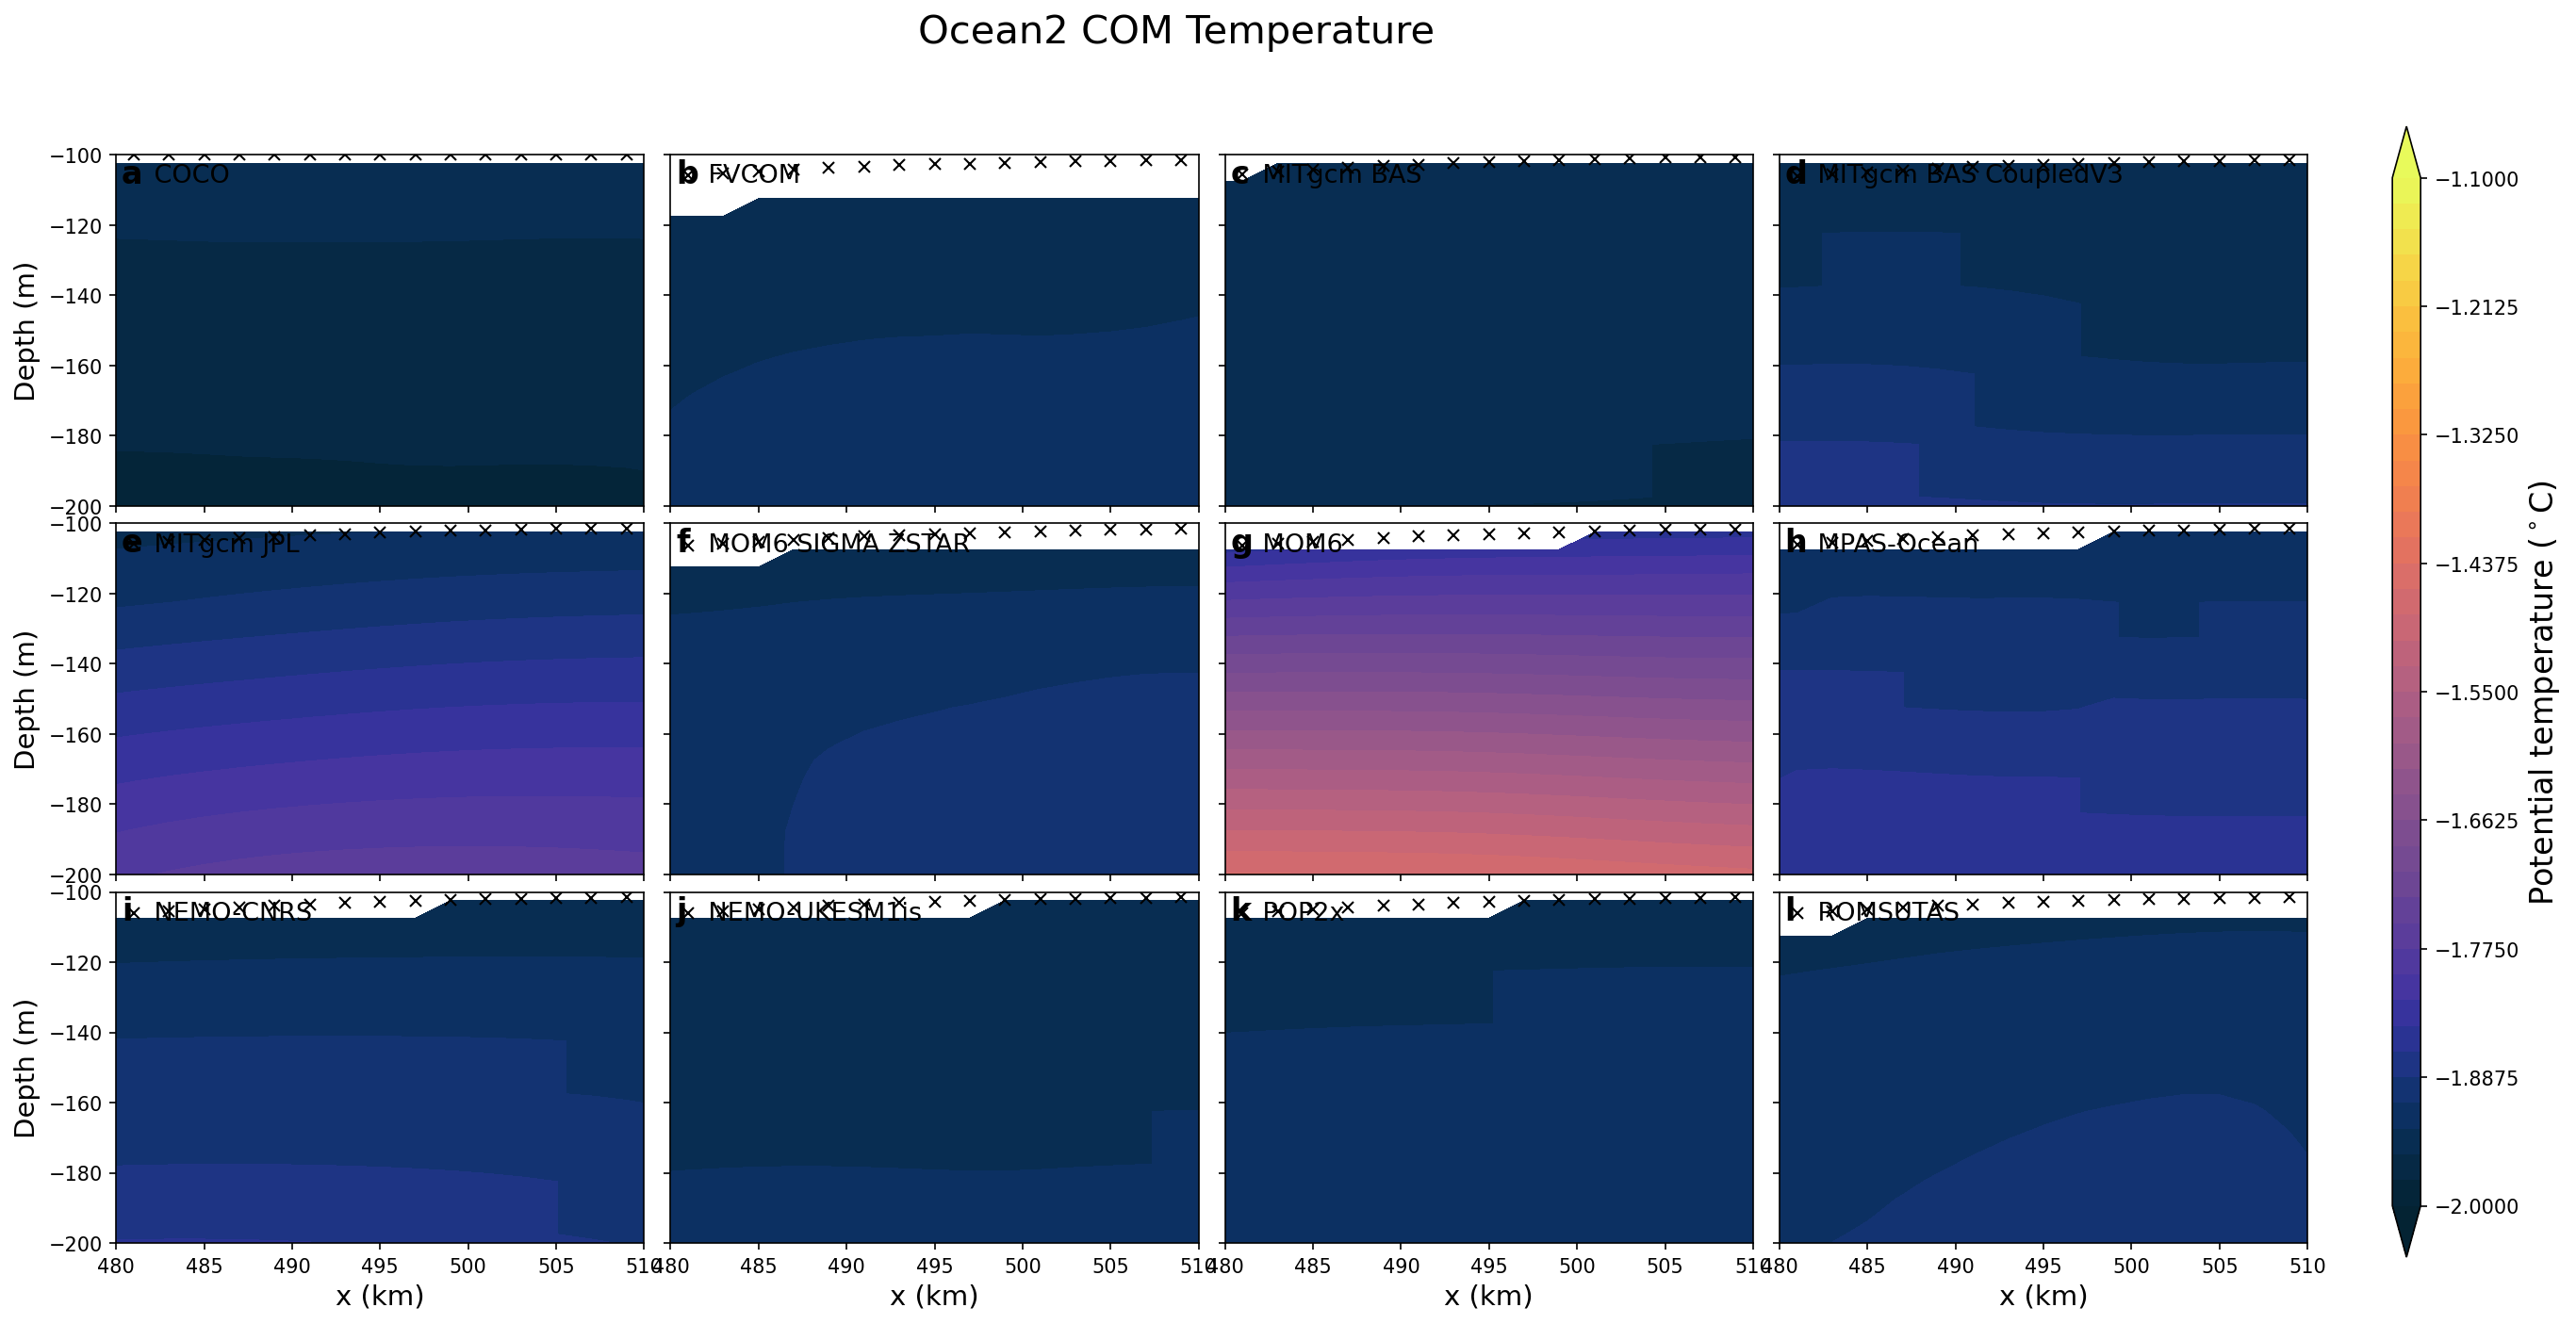

In [183]:
import matplotlib.gridspec as gridspec

expt = Ocean2_COM
labels = []
for fileIndex in range(len(expt)):
    fileName = expt[fileIndex]
    baseName = os.path.basename(basedrive +fileName)
    modelName = ' '.join(baseName.split('_')[2:]).split('.')[0]
    labels.append(modelName)
length = len(expt)
alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m']
ncols = int(np.ceil(length/3))

gs = gridspec.GridSpec(nrows=3,ncols=ncols,wspace=0.05, hspace=0.05)
fig = plt.figure(figsize=(20,10),facecolor='w',dpi = 150)


time = 240 #NOTE TO REMEMBER TO CHANGE THIS!!
for i in np.arange(length):
    # ax = plt.subplot(3,nrows,i+1)
    ax=fig.add_subplot(gs[i])
    data = xr.open_dataset(basedrive+expt[i], decode_times=False)
    var = data.temperatureXZ.isel(nTime = np.arange(time-13,time)).mean('nTime')
    # last year of time
    var['nz'] = var.nz*5+2.5 # add depth (2.5,7.5 etc)
    var['nx'] = var.nx*2+321
    # find ice draft for this transect
    iceDraft = data.iceDraft.isel(ny=20)
    try:
        iceDraft = iceDraft.isel(nTime = np.arange(time-13,time)).mean('nTime')
        print('removing time dimension from '+labels[i]+' ice draft')
    except ValueError:
        print('no time dimension in ',labels[i],' ice draft')
        
    print('CHECK is this the correct transect location?')
    #some models have a flipped iceDraft...
    if iceDraft.isel(nx=100)>0:
        iceDraft = -iceDraft
        print('This model ',expt[i],' has an inverted iceDraft - flipping to match others')

    #reshape to be 2d field
    iceDraft = np.tile(iceDraft,(len(var.nz),1))
    # make proper transect x,z locations
    NZ = (np.tile(var.nz.values,[len(var.nx),1])).T
    NX = (np.tile(var.nx.values,[len(var.nz),1]))
    # mr<1e36 is to get rid of NaNs.
    #c = (var.where(var <1e36)).plot.contourf(cmap = cm.cm.thermal, levels = np.linspace(-2,1,41),extend = 'both',add_colorbar = False)#, cbar_kwargs = {'label':'Overturning \n Streamfunction (Sv)'},extend = 'both')
    c = plt.contourf(NX,-(NZ),(var.where(var <1e36)),cmap = cm.cm.thermal, levels = np.linspace(-2,-1.1,41),extend = 'both')
    poi = plt.plot(NX[0,:],iceDraft[0,:],'kx')
    # ls = (var.where(var <1e36)).plot.contour( levels = np.linspace(-2,1,21), colors = 'k', linewidths = 0.4)
    plt.text(0.01,0.99,alphabet[i], fontsize = 16, transform=ax.transAxes, fontweight='bold', va='top')
    plt.text(0.01,0.975,'    '+labels[i], fontsize = 13, transform=ax.transAxes, va='top')
    # ax.grid()

    if (i==1) or (i==2) or (i==3) or (i==5) or (i==6) or (i==7) or (i==9) or (i==10) or (i==11):
        ax.set_yticklabels([])
    if (i<8):
        ax.set_xticklabels([])
        
    if (i==0) or (i==4) or (i==8):
        plt.ylabel('Depth (m)',fontsize=14)
    else:
        plt.ylabel('')
    if i>=8:
        plt.xlabel('x (km)',fontsize=14)
    else:
        plt.xlabel('')
    plt.ylim(-200,-100)
    plt.xlim(480,510)


cax = plt.axes([0.93,0.1,0.01,0.8])
cbar = plt.colorbar(c, cax = cax)
cbar.ax.set_ylabel(r'Potential temperature ($^\circ $C)', fontsize = 16)
# cbar.add_lines(ls)

fig.suptitle('Ocean2 COM Temperature', fontsize = 20);